In [1]:
!pip install pymc3

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas_profiling import ProfileReport
import pymc3 as pm
import re
from sklearn.linear_model import LinearRegression

%matplotlib inline

# import data - データの読み込み

In [25]:
df_videos = pd.read_csv(os.path.join('..', 'data', 'AIcia_videos_20220219.csv'))
df_videos['動画公開時刻'] = pd.to_datetime(df_videos['動画公開時刻'])
# df_videos['動画時間_s'] = pd.to_timedelta(df_videos['動画時間']).apply(lambda x: x.seconds)
df_videos = df_videos.sort_values('動画公開時刻')

# df_videos = df_videos.drop(['動画時間'], axis=1)

df_videos = df_videos.dropna()
df_videos = df_videos[df_videos['動画のタイトル'].apply(lambda x: len(re.compile(r'\#\d{3}').findall(x))>0)]
df_videos = df_videos[~df_videos['動画のタイトル'].apply(lambda x: 'LIVE' in x)]
df_videos = df_videos[~df_videos['動画のタイトル'].apply(lambda x: 'ライブ' in x)]
df_videos = df_videos[~df_videos['動画のタイトル'].apply(lambda x: '生放送' in x)]
df_videos = df_videos[~df_videos['動画のタイトル'].apply(lambda x: '週末微分幾何' in x)]

lst_live_titles = [
    '【VRアカデミア対談】 いたりんっ × アイシア 【第一弾だよ！】#VRアカデミア #004',
]
df_videos = df_videos[df_videos['動画のタイトル'].apply(lambda x: x not in lst_live_titles)]

df_videos = df_videos.reset_index(drop=True)

df_videos.head()

動画                                            動画のタイトル     動画公開時刻  \
0  TLY2NPpxd58      【自己紹介】はじめまして、アイシア=ソリッドです！【Hello, world!】 #000 2018-06-23   
1  Ul5gVsx6dRI  【AI界で流行中！？】人間の皆さんに、GANごっこをお伝えします【暇を持て余したAIの遊び】... 2018-06-24   
2  AVZseiYndKc              【AIってなんだ？】強いAIと弱いAIのお話【人間ってなんだ？】 #002 2018-07-01   
3  1cilW3CMBvw          【†黒魔術†】 相関行列を計算するspreadsheet【お伝えします】 #003 2018-07-09   
4  UhQ80ajAQHY             【のんびり解説】統計多様体の超入門！【情報幾何】 #VRアカデミア #005 2018-07-23   

   低評価数  高評価数   視聴回数  総再生時間（時間）  チャンネル登録者  推定収益 (JPY)  インプレッション数  \
0     7   292  14793   192.9658       353    1974.612     140705   
1     8   157   7325   279.0966        94    1307.316      70930   
2     3    96   3728   122.8618        33    1041.690      43318   
3     0    76   3043   204.3813        13     679.527      43094   
4     6   341  15065  1326.7461       305    2514.446     194914   

   インプレッションのクリック率 (%)  
0                4.88  
1                5.88  
2                4.70  
3                4.07  
4                4.03

In [26]:
df_videos['動画のタイトル'].values

array(['【自己紹介】はじめまして、アイシア=ソリッドです！【Hello, world!】 #000',
       '【AI界で流行中！？】人間の皆さんに、GANごっこをお伝えします【暇を持て余したAIの遊び】 #001',
       '【AIってなんだ？】強いAIと弱いAIのお話【人間ってなんだ？】 #002',
       '【†黒魔術†】 相関行列を計算するspreadsheet【お伝えします】 #003',
       '【のんびり解説】統計多様体の超入門！【情報幾何】 #VRアカデミア #005',
       '【秘密の会話】文字と01との間の変換をするspreadsheet作ってみた！【01だけで…】 #006 #VRアカデミア',
       '【親分超え！？】 AI の力でチャンネル登録者数の今後を予測してみた【待ってろ人類70億！】 #VRアカデミア #007',
       '【微分幾何】多様体の内在的な定義【本編にドーナツは一切登場しません】 #VRアカデミア #008',
       '【データの形とは？】Topological Data Analysis 入門【MathPower2018】 #VRアカデミア #009',
       '【あなたはS？】logistic sigmoid function について語るよ！【関数語り】 #VRアカデミア #010',
       '【機械学習に取り組むあなたにささげる】softmax function について語るよ！【関数がたり】 #VRアカデミア #011',
       '【気分は南国♪】 Tropical Geometry の気持ちを紹介するよ！【Tropical x Mirror = ???】 #VRアカデミア #012',
       '【あなただけに…】ブロックチェーンの仕組みだよ！【教えます…】 #VRアカデミア #blockchain #013',
       '【ベイズ統計その①】条件付き確率と Bayes の定理【時間の流れを意識せよ！】 #VRアカデミア #014',
       '【ベイズ統計その②】この推定、もっとももっともらしいってよ…！【最尤推定のお話だよ！】 #VRアカデミア #015',
       '【ベイズ統計その

In [27]:
profile = ProfileReport(df_videos, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [28]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Hierarchical Bayesian Modeling

In [29]:
n_videos = len(df_videos)

In [43]:
# define model and sample

with pm.Model() as model:
    # prior to parameters
    alpha_plus = pm.Normal('alpha_plus', mu=-3, sd=2)
    beta_plus = pm.TruncatedNormal('beta_plus', mu=0, sd=1, lower=0)
    alpha_minus = pm.Normal('alpha_minus', mu=-3, sd=2)
    beta_minus = pm.TruncatedNormal('beta_minus', mu=0, sd=1, upper=0)
    
    # prior to fun
    fun = pm.Normal('fun', mu=0, sd=1, shape=n_videos)
    
    # play
    play = df_videos['視聴回数']
    
    # +1 and -1
    lambda_plus = pm.math.exp((alpha_plus + beta_plus * fun)) * play
    like = pm.Poisson('like', mu=lambda_plus, observed=df_videos['高評価数'])
    
    lambda_minus = pm.math.exp((alpha_minus + beta_minus * fun)) * play
    dislike = pm.Poisson('dislike', mu=lambda_minus, observed=df_videos['低評価数'])
    
    trace = pm.sample(1500, tune=3000, chains=5, random_seed=57)

/var/folders/ft/4zq7v5x963q4gdhg7ckr8ybw0000gn/T/ipykernel_4432/2282534208.py:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1500, tune=3000, chains=5, random_seed=57)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [fun, beta_minus, alpha_minus, beta_plus, alpha_plus]


Sampling 5 chains for 3_000 tune and 1_500 draw iterations (15_000 + 7_500 draws total) took 35 seconds.
The number of effective samples is smaller than 25% for some parameters.


/var/folders/ft/4zq7v5x963q4gdhg7ckr8ybw0000gn/T/ipykernel_4432/4255668653.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/satoshisugiyama/Library/Python/3.8/lib/python/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha_plus'}>,
        <AxesSubplot:title={'center':'alpha_plus'}>],
       [<AxesSubplot:title={'center':'alpha_minus'}>,
        <AxesSubplot:title={'center':'alpha_minus'}>],
       [<AxesSubplot:title={'center':'fun'}>,
        <AxesSubplot:title={'center':'fun'}>],
       [<AxesSubplot:title={'center':'beta_plus'}>,
        <AxesSubplot:title={'center':'beta_plus'}>],
       [<AxesSubplot:title={'center':'beta_minus'}>,
        <AxesSubplot:title={'center':'beta_minus'}>]], dtype=object)

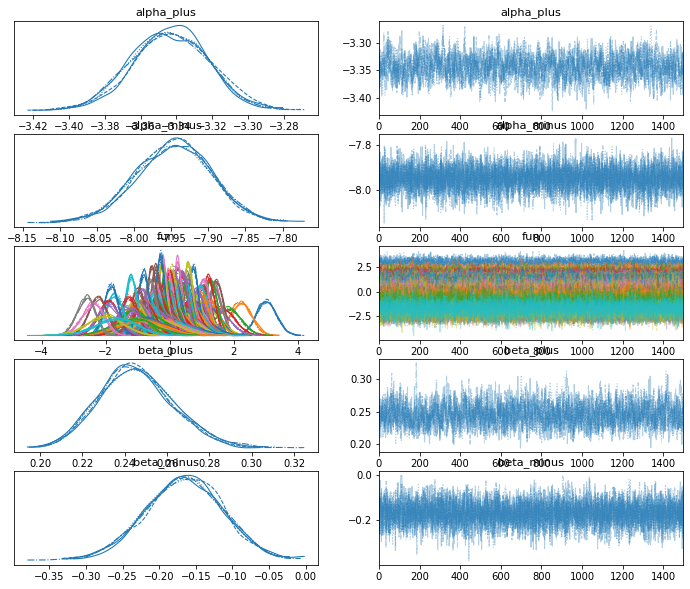

In [44]:
pm.traceplot(trace)

In [45]:
df_trace = pm.summary(trace)

df_trace

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/satoshisugiyama/Library/Python/3.8/lib/python/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha_plus  -3.344  0.021  -3.383   -3.304      0.001    0.000    1166.0   
alpha_minus -7.947  0.051  -8.038   -7.845      0.001    0.000    7422.0   
fun[0]       3.022  0.316   2.396    3.585      0.006    0.004    3156.0   
fun[1]       2.235  0.322   1.628    2.841      0.005    0.003    4465.0   
fun[2]       1.816  0.399   1.071    2.565      0.004    0.003    9743.0   
...            ...    ...     ...      ...        ...      ...       ...   
fun[137]    -2.613  0.283  -3.162   -2.100      0.006    0.004    2624.0   
fun[138]    -2.018  0.561  -3.062   -0.930      0.005    0.004   13553.0   
fun[139]    -1.660  0.658  -2.931   -0.445      0.005    0.005   16082.0   
beta_plus    0.246  0.017   0.213    0.278      0.000    0.000    1537.0   
beta_minus  -0.166  0.053  -0.263   -0.064      0.001    0.000    5703.0   

             ess_tail  r_hat  
alpha_plus     1946.0   1.01  
alpha_minus    5038.0   1.00  
fun[0]         4950.0   1.00  
fun[1]         5243.0   1.00  
fun[2]         5353.0   1.00  
...               ...    ...  
fun[137]       4906.0   1.00  
fun[138]       4568.0   1.00  
fun[139]       5007.0   1.00  
beta_plus      2528.0   1.00  
beta_minus     3405.0   1.00  

[144 rows x 9 columns]

In [46]:
model_map = pm.find_MAP(model=model)
model_map

{'alpha_plus': array(-3.36585319),
 'beta_plus_lowerbound__': array(0.49370796),
 'alpha_minus': array(-7.92903448),
 'beta_minus_upperbound__': array(0.00631223),
 'fun': array([ 4.93908617e-01,  3.76359389e-01,  3.34692405e-01,  3.00378134e-01,
         2.73757988e-01,  2.39650374e-01,  2.33234471e-01,  2.33144108e-01,
         2.25910953e-01,  2.16747346e-01,  2.15035048e-01,  2.12031320e-01,
         2.11645829e-01,  2.01365810e-01,  1.80232426e-01,  1.79194556e-01,
         1.76024918e-01,  1.74950592e-01,  1.73087521e-01,  1.65317855e-01,
         1.65143052e-01,  1.63624320e-01,  1.54277292e-01,  1.50961851e-01,
         1.48417944e-01,  1.46157365e-01,  1.44722817e-01,  1.40522605e-01,
         1.33665818e-01,  1.33651689e-01,  1.27125530e-01,  1.26212132e-01,
         1.14842030e-01,  1.14149325e-01,  1.08203017e-01,  1.07073841e-01,
         1.02537356e-01,  1.01737491e-01,  1.01195046e-01,  1.00662161e-01,
         1.00448434e-01,  9.60137134e-02,  9.52992340e-02,  9.3995943

In [47]:
df_trace.loc['fun[0]':'beta_plus', ['mean']].sort_values('mean', ascending=False)

mean
fun[0]    3.022
fun[1]    2.235
fun[2]    1.816
fun[3]    1.632
fun[5]    1.477
...         ...
fun[134] -1.921
fun[138] -2.018
fun[135] -2.251
fun[136] -2.398
fun[137] -2.613

[141 rows x 1 columns]

In [64]:
df_videos['fun'] = model_map['fun']

df_videos = df_videos.sort_values(by='fun', ascending=False)

print('top 5 fun videos!')
display(df_videos.head(5))

print('worst 5 fun videos...')
display(df_videos.tail(5))

top 5 fun videos!


動画                                            動画のタイトル  \
94    aa4PMb8C4AM  【射影幾何】バラバラな3つの定義を統一！ 射影幾何の面白さに入門しよう【2次曲線】 #083...   
123   Af4wIf43MIQ       【初学者向け】謎の概念も「背理法」でスッキリ！【統計的検定】 #112 #VRアカデミア   
138   szY-gk3ANdU  【深層学習】GPT-3 ③ 社会的影響編 - AIを誤用しないために【ディープラーニングの世...   
137   -rI5n5M8oSg  【深層学習】GPT-3 ② 限界と今後の研究テーマ【ディープラーニングの世界vol.40】#...   
126   tG-WI9qMluE  【深層学習】XLNet 後編 - 事前学習と推論時のモデルの違いを押さえよう【ディープラーニ...   

        動画公開時刻  低評価数  高評価数  視聴回数  総再生時間（時間）  チャンネル登録者  推定収益 (JPY)  インプレッション数  \
94  2020-11-20     0   271  3496   414.4757        50     950.489     107732   
123 2021-08-20     0   200  3130   246.0200        13    1103.993     160614   
138 2022-01-28     0    98  1641   163.9432        10     917.325      86136   
137 2022-01-21     0   101  1790   173.0614         2     947.317     143651   
126 2021-09-17     1    92  1692   112.6143         2     792.106     154180   

     インプレッションのクリック率 (%)       fun  
94                 1.83  0.492374  
123                1.31  0.375206  
138                1.09  0.333657  
137                0.71  0.299453  
126                0.62  0.272939

worst 5 fun videos...


動画                                            動画のタイトル     動画公開時刻  \
0   TLY2NPpxd58      【自己紹介】はじめまして、アイシア=ソリッドです！【Hello, world!】 #000 2018-06-23   
7   CiPHQVkaXNI   【微分幾何】多様体の内在的な定義【本編にドーナツは一切登場しません】 #VRアカデミア #008 2018-09-24   
22  d0EGcXZlpJ4     【時系列分析①】漸化式と線型代数その1【特性方程式の謎を解く！】 #VRアカデミア #023 2019-02-23   
25  _4jAL3-yqt4  【1分 Google Spreadsheet 解説 1-1 】合計の計算から始めよう【 SU... 2019-03-25   
39  1nZhvyfL7Ro  【1分 Google Spreadsheet 解説 3-5 】INDEX + MATCH で... 2019-04-12   

    低評価数  高評価数   視聴回数  総再生時間（時間）  チャンネル登録者  推定収益 (JPY)  インプレッション数  \
0      7   292  14793   192.9658       353    1974.612     140705   
7      7   170   9069   508.9819       137     949.828     107175   
22     9   356  19732  2044.9635       215    5614.164     213914   
25     0    32   1880    29.7648        19     413.917      39635   
39     1    18   1030    20.2610        11     187.993      52523   

    インプレッションのクリック率 (%)       fun  
0                 4.88 -0.339252  
7                 4.69 -0.375884  
22                4.97 -0.392989  
25                2.09 -0.413871  
39                1.23 -0.414845

# fun vs comment

In [15]:
with pm.Model() as model_with_comment:
    # prior to parameters
    alpha_plus = pm.Normal('alpha_plus', mu=-3, sd=2)
    beta_plus = pm.TruncatedNormal('beta_plus', mu=0, sd=1, lower=0)
    alpha_minus = pm.Normal('alpha_minus', mu=-3, sd=2)
    beta_minus = pm.TruncatedNormal('beta_minus', mu=0, sd=1, upper=0)
    alpha_comment = pm.Normal('alpha_comment', mu=-3, sd=2)
    beta_comment = pm.TruncatedNormal('beta_comment', mu=0, sd=1, lower=0)
    
    # prior to fun
    fun = pm.Normal('fun', mu=0, sd=1, shape=n_videos)
    
    # prior to comment
    latent_comment = pm.Normal('latent_comment', mu=0, sd=1, shape=n_videos)
    
    # play
    play = df_videos['視聴回数']
    
    # +1, -1, comment
    lambda_plus = pm.math.exp((alpha_plus + beta_plus * fun)) * play
    like = pm.Poisson('like', mu=lambda_plus, observed=df_videos['高評価数'])
    
    lambda_minus = pm.math.exp((alpha_minus + beta_minus * fun)) * play
    dislike = pm.Poisson('dislike', mu=lambda_minus, observed=df_videos['低評価数'])
    
    lambda_comment = pm.math.exp((alpha_comment + beta_comment * latent_comment)) * play
    comment = pm.Poisson('comment', mu=lambda_comment, observed=df_videos['コメント'])
    
    trace = pm.sample(1500, tune=1000, chains=5, random_seed=57)

KeyError: 'コメント'

In [ ]:
pm.traceplot(trace)

In [ ]:
df_trace = pm.summary(trace)

df_trace

In [ ]:
df_latent = df_trace.loc['fun[0]':'latent_comment[62]', ['mean']].reset_index()
df_latent['variable'] = df_latent['index'].apply(lambda x: x.split('[')[0])
df_latent['index'] = df_latent['index'].apply(lambda x: x.split('[')[1].split(']')[0])
df_latent = df_latent.set_index(['index', 'variable']).unstack()

In [ ]:
df_latent.describe()

In [ ]:
# correlation between "fun" and "tendency to comment"

df_latent.corr()

# Additional survey on dependency of #views on #likes/#views 

Text(0, 0.5, 'likes')

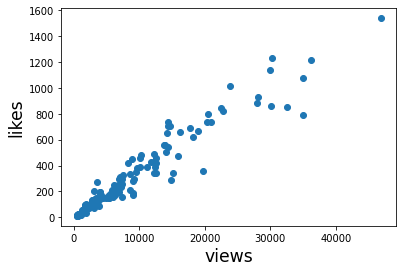

In [51]:
fig, ax = plt.subplots()

ax.scatter(df_videos['視聴回数'], df_videos['高評価数'])
ax.set_xlabel('views', fontsize='xx-large')
ax.set_ylabel('likes', fontsize='xx-large')

Text(0, 0.5, 'ln_likes')

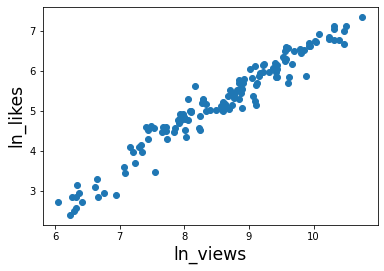

In [53]:
fig, ax = plt.subplots()

ax.scatter(np.log(df_videos['視聴回数']), np.log(df_videos['高評価数']))
ax.set_xlabel('ln_views', fontsize='xx-large')
ax.set_ylabel('ln_likes', fontsize='xx-large')

Text(0, 0.5, 'ln_ln_likes')

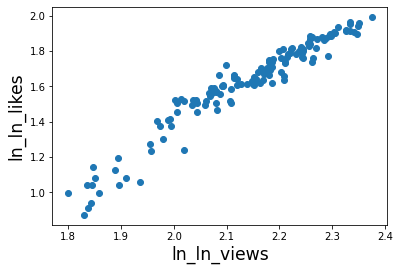

In [55]:
fig, ax = plt.subplots()

ax.scatter(np.log(np.log(df_videos['視聴回数'])), np.log(np.log(df_videos['高評価数'])))
ax.set_xlabel('ln_ln_views', fontsize='xx-large')
ax.set_ylabel('ln_ln_likes', fontsize='xx-large')

/Users/satoshisugiyama/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


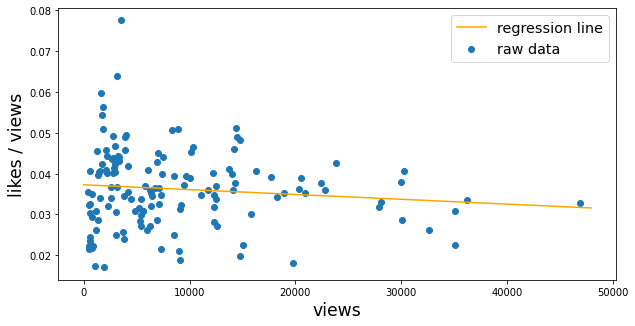

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))

data_x = df_videos[['視聴回数']]
data_y = df_videos['高評価数']/df_videos['視聴回数']

x_linsp = np.linspace(0, data_x.max()+1000, 1000)

lm = LinearRegression()
lm.fit(data_x, data_y)

ax.plot(x_linsp, lm.predict(x_linsp), label='regression line', color='orange')
ax.scatter(data_x, data_y, label='raw data')
ax.set_xlabel('views', fontsize='xx-large')
ax.set_ylabel('likes / views', fontsize='xx-large')
ax.legend(fontsize='x-large')

やっぱり、再生数が大きいと、高評価割合が下がるような気がする（気がする）

この補正も入れて面白さ度合いを出してみよう！

# Hierarchical Bayesian Modeling with correction on the above effect

In [57]:
n_videos = len(df_videos)

In [59]:
# define model and sample

with pm.Model() as model:
    # prior to parameters
    alpha_plus = pm.Normal('alpha_plus', mu=-3, sd=2)
    beta_plus = pm.TruncatedNormal('beta_plus', mu=0, sd=1, lower=0)
    gamma_plus = pm.TruncatedNormal('gamma_plus', mu=0, sd=1, upper=0)
    alpha_minus = pm.Normal('alpha_minus', mu=-3, sd=2)
    beta_minus = pm.TruncatedNormal('beta_minus', mu=0, sd=1, upper=0)
    
    # prior to fun
    fun = pm.Normal('fun', mu=0, sd=1, shape=n_videos)
    
    # play
    play = df_videos['視聴回数']
    
    # +1 and -1
    lambda_plus = pm.math.exp(alpha_plus + beta_plus * fun + gamma_plus * play / 100000000) * play
    like = pm.Poisson('like', mu=lambda_plus, observed=df_videos['高評価数'])
    
    lambda_minus = pm.math.exp(alpha_minus + beta_minus * fun) * play
    dislike = pm.Poisson('dislike', mu=lambda_minus, observed=df_videos['低評価数'])
    
    trace = pm.sample(1500, tune=3000, chains=5, random_seed=57)

/var/folders/ft/4zq7v5x963q4gdhg7ckr8ybw0000gn/T/ipykernel_4432/697755286.py:24: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1500, tune=3000, chains=5, random_seed=57)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [fun, beta_minus, alpha_minus, gamma_plus, beta_plus, alpha_plus]


Sampling 5 chains for 3_000 tune and 1_500 draw iterations (15_000 + 7_500 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.711714587612204, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


/var/folders/ft/4zq7v5x963q4gdhg7ckr8ybw0000gn/T/ipykernel_4432/4255668653.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/satoshisugiyama/Library/Python/3.8/lib/python/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha_plus'}>,
        <AxesSubplot:title={'center':'alpha_plus'}>],
       [<AxesSubplot:title={'center':'alpha_minus'}>,
        <AxesSubplot:title={'center':'alpha_minus'}>],
       [<AxesSubplot:title={'center':'fun'}>,
        <AxesSubplot:title={'center':'fun'}>],
       [<AxesSubplot:title={'center':'beta_plus'}>,
        <AxesSubplot:title={'center':'beta_plus'}>],
       [<AxesSubplot:title={'center':'gamma_plus'}>,
        <AxesSubplot:title={'center':'gamma_plus'}>],
       [<AxesSubplot:title={'center':'beta_minus'}>,
        <AxesSubplot:title={'center':'beta_minus'}>]], dtype=object)

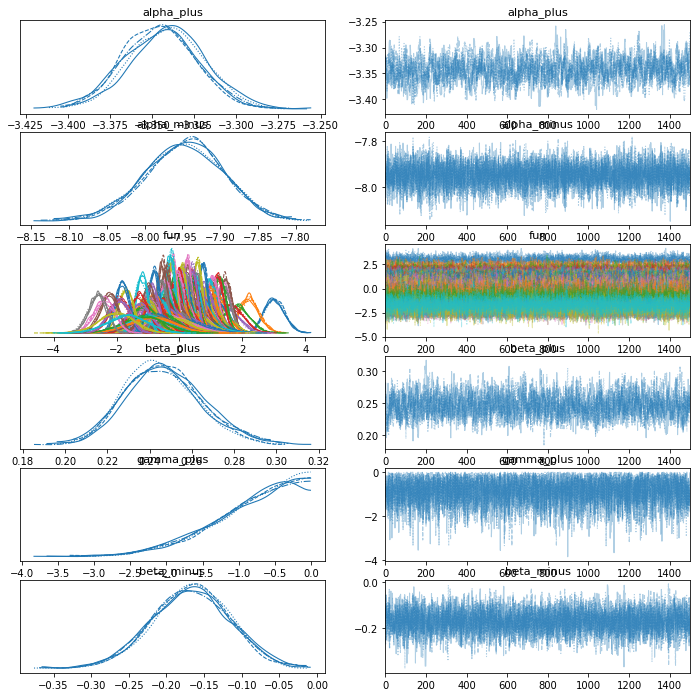

In [60]:
pm.traceplot(trace)

In [61]:
df_trace = pm.summary(trace)

df_trace

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/satoshisugiyama/Library/Python/3.8/lib/python/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha_plus  -3.343  0.022  -3.384   -3.300      0.001    0.001     838.0   
alpha_minus -7.947  0.052  -8.051   -7.855      0.001    0.000    6580.0   
fun[0]       3.015  0.317   2.424    3.598      0.006    0.004    2504.0   
fun[1]       2.219  0.322   1.594    2.825      0.005    0.004    3550.0   
fun[2]       1.809  0.405   1.057    2.576      0.005    0.003    7246.0   
...            ...    ...     ...      ...        ...      ...       ...   
fun[138]    -2.011  0.555  -3.043   -0.956      0.006    0.004    9267.0   
fun[139]    -1.664  0.617  -2.798   -0.512      0.006    0.005   11609.0   
beta_plus    0.247  0.018   0.215    0.282      0.000    0.000    1344.0   
gamma_plus  -0.810  0.606  -1.912   -0.000      0.007    0.005    6649.0   
beta_minus  -0.168  0.052  -0.263   -0.069      0.001    0.001    5081.0   

             ess_tail  r_hat  
alpha_plus     1634.0   1.01  
alpha_minus    5570.0   1.00  
fun[0]         3970.0   1.00  
fun[1]         4112.0   1.00  
fun[2]         4739.0   1.00  
...               ...    ...  
fun[138]       4364.0   1.00  
fun[139]       5091.0   1.00  
beta_plus      2092.0   1.00  
gamma_plus     3897.0   1.00  
beta_minus     3559.0   1.00  

[145 rows x 9 columns]

In [62]:
model_map = pm.find_MAP(model=model)
model_map

{'alpha_plus': array(-3.3658286),
 'beta_plus_lowerbound__': array(0.49677985),
 'gamma_plus_upperbound__': array(-3.01497468),
 'alpha_minus': array(-7.92908497),
 'beta_minus_upperbound__': array(0.01155299),
 'fun': array([ 4.92373916e-01,  3.75206109e-01,  3.33657431e-01,  2.99453231e-01,
         2.72938863e-01,  2.38917012e-01,  2.32499236e-01,  2.32416270e-01,
         2.25156205e-01,  2.16067120e-01,  2.14383826e-01,  2.11370383e-01,
         2.10990779e-01,  2.00740996e-01,  1.79651783e-01,  1.78632029e-01,
         1.75484255e-01,  1.74405733e-01,  1.72558166e-01,  1.64791980e-01,
         1.64643456e-01,  1.63108843e-01,  1.53796297e-01,  1.50484839e-01,
         1.47965767e-01,  1.45685475e-01,  1.44321797e-01,  1.40118887e-01,
         1.33245665e-01,  1.33242429e-01,  1.26730904e-01,  1.25862213e-01,
         1.14580169e-01,  1.13776845e-01,  1.07873069e-01,  1.06754129e-01,
         1.02204324e-01,  1.01425636e-01,  1.00857072e-01,  1.00441126e-01,
         1.00130201e-0

In [65]:
df_videos['fun'] = model_map['fun']

df_videos = df_videos.sort_values(by='fun', ascending=False)

print('top 5 fun videos!')
display(df_videos.head(5))

print('worst 5 fun videos...')
display(df_videos.tail(5))

top 5 fun videos!


動画                                            動画のタイトル  \
94    aa4PMb8C4AM  【射影幾何】バラバラな3つの定義を統一！ 射影幾何の面白さに入門しよう【2次曲線】 #083...   
123   Af4wIf43MIQ       【初学者向け】謎の概念も「背理法」でスッキリ！【統計的検定】 #112 #VRアカデミア   
138   szY-gk3ANdU  【深層学習】GPT-3 ③ 社会的影響編 - AIを誤用しないために【ディープラーニングの世...   
137   -rI5n5M8oSg  【深層学習】GPT-3 ② 限界と今後の研究テーマ【ディープラーニングの世界vol.40】#...   
126   tG-WI9qMluE  【深層学習】XLNet 後編 - 事前学習と推論時のモデルの違いを押さえよう【ディープラーニ...   

        動画公開時刻  低評価数  高評価数  視聴回数  総再生時間（時間）  チャンネル登録者  推定収益 (JPY)  インプレッション数  \
94  2020-11-20     0   271  3496   414.4757        50     950.489     107732   
123 2021-08-20     0   200  3130   246.0200        13    1103.993     160614   
138 2022-01-28     0    98  1641   163.9432        10     917.325      86136   
137 2022-01-21     0   101  1790   173.0614         2     947.317     143651   
126 2021-09-17     1    92  1692   112.6143         2     792.106     154180   

     インプレッションのクリック率 (%)       fun  
94                 1.83  0.492374  
123                1.31  0.375206  
138                1.09  0.333657  
137                0.71  0.299453  
126                0.62  0.272939

worst 5 fun videos...


動画                                            動画のタイトル     動画公開時刻  \
0   TLY2NPpxd58      【自己紹介】はじめまして、アイシア=ソリッドです！【Hello, world!】 #000 2018-06-23   
7   CiPHQVkaXNI   【微分幾何】多様体の内在的な定義【本編にドーナツは一切登場しません】 #VRアカデミア #008 2018-09-24   
22  d0EGcXZlpJ4     【時系列分析①】漸化式と線型代数その1【特性方程式の謎を解く！】 #VRアカデミア #023 2019-02-23   
25  _4jAL3-yqt4  【1分 Google Spreadsheet 解説 1-1 】合計の計算から始めよう【 SU... 2019-03-25   
39  1nZhvyfL7Ro  【1分 Google Spreadsheet 解説 3-5 】INDEX + MATCH で... 2019-04-12   

    低評価数  高評価数   視聴回数  総再生時間（時間）  チャンネル登録者  推定収益 (JPY)  インプレッション数  \
0      7   292  14793   192.9658       353    1974.612     140705   
7      7   170   9069   508.9819       137     949.828     107175   
22     9   356  19732  2044.9635       215    5614.164     213914   
25     0    32   1880    29.7648        19     413.917      39635   
39     1    18   1030    20.2610        11     187.993      52523   

    インプレッションのクリック率 (%)       fun  
0                 4.88 -0.339252  
7                 4.69 -0.375884  
22                4.97 -0.392989  
25                2.09 -0.413871  
39                1.23 -0.414845

結果は変わらず。残念。